# MXNet NumPy

*"Everybody loves numpy"*

In this tutorial, we present `minpy` -- a `numpy`-like package based on `MXNet`. `numpy` is a well-known python package widely used in scientific computing, statistics and machine learning. It supports a wide range of tensor operators and is very friendly to machine learning beginners. Here, we will walk with you through a simple example of *logistic regression* using `numpy`. After that we will illustrate how `minpy` utilizes GPUs to speed up your machine learning algorithm with few (or no) change in your original `numpy` code. We hope by following this direction, we could solve the ultimate trade-off that every machine learning tools are facing with: *how to achieve both efficiency and flexibility?*

In [1]:
# A bit of setup, just ignore this cell

import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Multinomial Logistic Regression using NumPy

Logistic regression is a supervised machine learning algorithm that is commonly used in classification. The "supervised" word here means each data sample (represented by a float vector) is *labeled*. We have provided some util functions to fetch some generated data for you.

In [2]:
import numpy as np
import numpy.random as random
import time
from util import get_data, plot_data

# Initialize training data
data, label = get_data()
num_samples = data.shape[0]
num_features = data.shape[1]
num_classes = label.shape[1]

print 'Shapes: data {}, label {}'.format(data.shape, label.shape)
print '# samples: {}'.format(num_samples)
print '# features: {}'.format(num_features)
print '# classes: {}'.format(num_classes)

Shapes: data (10000, 500), label (10000, 5)
# samples: 10000
# features: 500
# classes: 5


In our example, the training data contains 10000 samples. Each sample has 500 features, so the training samples could be represented by a 10000x500 matrix. Our goal is to classify each samples into 5 classes. Therefore, each sample comes with a label which is encoded in *one-of-many* format. For example, say sample 0 is of class 1, then the corresponding label vector for sample 0 will be `[0, 1, 0, 0, 0]`. Therefore, label could be represented by a 10000x5 matrix as follows:

In [3]:
print 'Data matrix:'
print data
print 'Label matrix:'
print label

Data matrix:
[[ 0.32734496  0.38202421  0.88363333 ...,  0.56855788  0.77482872
   0.78661045]
 [ 0.30944119  0.31369851  0.7323332  ...,  0.52735346  0.54504115
   0.86898225]
 [ 0.37802308  0.43419765  0.66645294 ...,  0.64980071  0.55614532
   0.76352769]
 ..., 
 [ 0.23139488  0.46588139  0.54704782 ...,  0.8856756   0.07421766
   0.61662582]
 [ 0.00828138  0.17924487  0.53160273 ...,  1.05838437  0.1968327
   0.63039901]
 [ 0.05748305  0.27938298  0.46694946 ...,  0.82950457  0.06558127
   0.6286073 ]]
Label matrix:
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


We provide a function `plot_data` for you to visualize what the data looks like. It projects each 500-D samples onto their first two dimensions, so each sample is a point in the figure. We distinguish samples of different classes using different colors. Although this is a very simple example, the idea behind is similar to more complicated examples you will encounter in the following tutorials. For example, if this is an *Optical Character Recognition (OCR)* task (like the MNIST example we are going to talk about), you could think about the blue points are the samples of digit "0" and red points are digit "1". Then our goal is to correctly classify some *unknown* samples (test data) into the most likely classes.

Ground truth


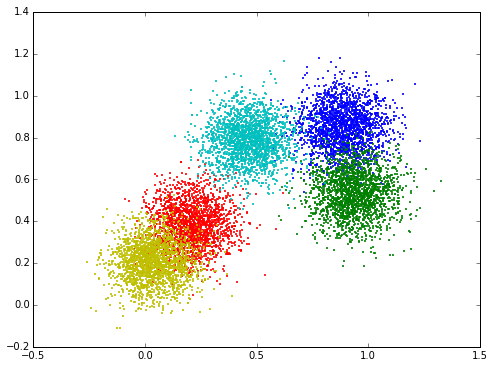

In [4]:
# Visualize what the ground truth data looks like
print 'Ground truth'
plot_data(data, label)

The model we are using here is called *Multinomial Logistic Regression*, or called Softmax Regression. Original logistic regression could only deal with binary classes (either 0 or 1) while multinomial logistic regression allows you to classify samples into multiple classes. The model contains a weight matrix `w` that projects from feature space to class space (so its dimension is `num_features` $\times$ `num_classes`). It first calculate the probability of each class given the samples:
$$p(y^{(i)}=j \mid x^{(i)};w)= \frac{\exp(w_j^Tx^{(i)})}{\sum_j\exp(w_j^Tx^{(i)})}$$
Try implement the following `predict` function that corresponds to the above math equation.

In [5]:
# predict the class using logistic regression
def predict(w, x):
    #===========================================================#
    #                    Your code starts here                  #
    #===========================================================#
    # please try compute the estimated probability of each sample
    a = np.exp(np.dot(x, w))
    a_sum = np.sum(a, axis=1, keepdims=True)
    prob = a / a_sum
    #===========================================================#
    #                    Your code ends here                    #
    #===========================================================#
    return prob

We could then use the above `predict` function to see what a random guess may look like. We first initialize the `weight` matrix using random numbers. Then feed the predict result into the `plot_data` function for visualization. You could see that, the random guess is completely different with the correct labels.

Initial Guess


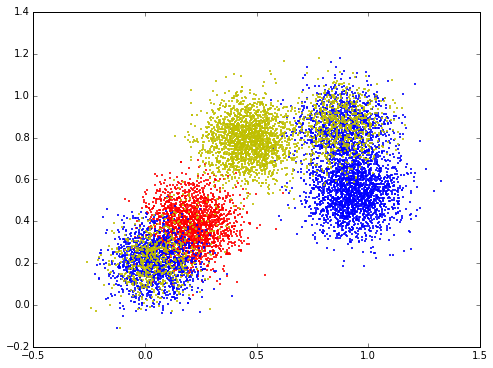

In [6]:
# Initialize training weight
weight = random.randn(num_features, num_classes)

# Visualize the initial guess
print 'Initial Guess'
plot_data(data, predict(weight, data))

Multinomial logistic regression then tries to minimize the *cross entropy* between the `predict` class probability and the correct probability. More specifically, it tries to minimize the following equation:
$$J(w)=-\frac{1}{m}\left[\sum_{i=1}^{m}\sum_{j=1}^{k}1\{y^{(i)}=j\}\log (p(y^{(i)}=j \mid x^{(i)};w))\right]$$
, where $m$ is the number of samples, $1\{...\}$ is the indicator function which equals 1 if the condition holds, otherwise equals 0.

Try implement the loss calculation in the following code. Note that our label (the correct probability) has already been transformed into *one-of-many* form, so the indicator function here is simply an element-wise multiplication of the label matrix and the logarithmic probability.

To minimize this function, we use a method called **batch gradient descent**. It first calculates the gradient of the weight matrix as follows:
$$\nabla_{w}J(w)=-\frac{1}{m}\sum_{i=1}^{m}\left[x^{(i)}(1\{y^{(i)}=j\}-p(y^{(i)}=j \mid x^{(i)};w))\right]$$
, then update the current model along the gradient direction:
$$w\leftarrow w - \alpha \nabla_{w}J(w)$$
We have implemented the gradient computation and the weight update for you.

In [7]:
# Using gradient descent to fit the correct classes
def train(w, x, loops):
    for i in range(loops):
        prob = predict(w, x)
        if i % 10 == 0:
            #===========================================================#
            #                    Your code starts here                  #
            #===========================================================#
            # please try compute the current loss value
            loss = -np.sum(np.log(prob) * label) / num_samples
            #===========================================================#
            #                    Your code ends here                    #
            #===========================================================#
            print 'Iter {}, training loss {}'.format(i, loss)
        # calculate gradient of weight
        dy = prob - label
        dw = np.dot(data.T, dy) / num_samples
        # update 
        w -= 0.1 * dw

Once you have finished the above codes, you could now try to optimize for 100 iterations. You should see the loss value keeps dropping.

In [8]:
# Now training it for 100 iterations
start_time = time.time()
train(weight, data, 100)
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 11.3204627753
Iter 10, training loss 0.182221836761
Iter 20, training loss 0.0822960642387
Iter 30, training loss 0.0519932875661
Iter 40, training loss 0.0372629108281
Iter 50, training loss 0.0287163128097
Iter 60, training loss 0.0232020461113
Iter 70, training loss 0.0193796141292
Iter 80, training loss 0.0165889129118
Iter 90, training loss 0.0144699216051
Training time: 8.81228685379s


Now you could visualize the prediction with trained model again. It should now be very close to what the ground truth is.

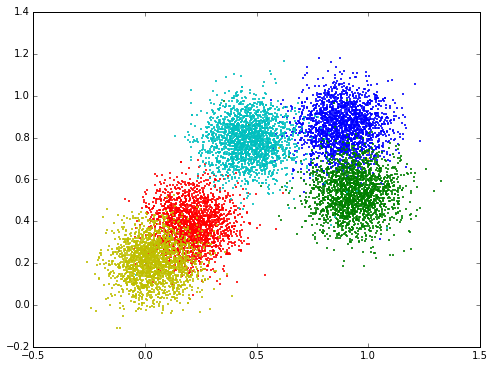

In [9]:
# Plot the prediction after training. It should show similar image as the ground truth.
plot_data(data, predict(weight, data))

## Multinomial Logistic Regression using MXNet NumPy

### Utilize GPU computation with little (or no) numpy syntax change

You could see even with such a tiny example, 100 iterations take around 9 seconds. In real world, there are billions of samples and much more features and classes. How to efficiently train such a model? One solution is to use GPU. Our tool, `minpy` allows you to use GPU to speed up the algorithm and in the meantime, keep the neat `numpy` syntax you just went through.

In [10]:
# All you need to do is replace the `np` namespace with minpy's.
import minpy.numpy as np
import minpy.numpy.random as random

I[0401 23:58:09 29937 mocking.py:25:__init__] Initialize module: minpy.numpy.random
I[0401 23:58:09 29937 mocking.py:33:__init__] Importing from minpy.array_variants.numpy.random
I[0401 23:58:09 29937 mocking.py:40:__init__] Got 52 primitives from minpy.array_variants.numpy.random
I[0401 23:58:09 29937 mocking.py:33:__init__] Importing from minpy.array_variants.mxnet.random
I[0401 23:58:09 29937 mocking.py:40:__init__] Got 2 primitives from minpy.array_variants.mxnet.random
I[0401 23:58:09 29937 mocking.py:44:__init__] Import 54 primitives
I[0401 23:58:09 29937 mocking.py:25:__init__] Initialize module: minpy.numpy
I[0401 23:58:09 29937 mocking.py:33:__init__] Importing from minpy.array_variants.numpy
I[0401 23:58:09 29937 mocking.py:40:__init__] Got 388 primitives from minpy.array_variants.numpy
I[0401 23:58:09 29937 mocking.py:33:__init__] Importing from minpy.array_variants.mxnet
I[0401 23:58:09 29937 mocking.py:40:__init__] Got 20 primitives from minpy.array_variants.mxnet
I[0401 2

In [11]:
# Initialize weight matrix (again)
weight = random.randn(num_features, num_classes)

# Now call the same training function
# Since the namespace is redefined, it will automatically run on GPU.
start_time = time.time()
train(weight, data, 100)
 # You should observe a significant speed up to the previous training time.
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 17.1077125
Iter 10, training loss 2.68464726562
Iter 20, training loss 0.380768286133
Iter 30, training loss 0.13968013916
Iter 40, training loss 0.0791123779297
Iter 50, training loss 0.0535990661621
Iter 60, training loss 0.0399287322998
Iter 70, training loss 0.0315322265625
Iter 80, training loss 0.0259011810303
Iter 90, training loss 0.0218860275269
Training time: 3.32867479324s


### Automatic gradient calculation

In [17]:
from minpy.core import grad_and_loss

# Initialize weight matrix (again)
weight = random.randn(num_features, num_classes)

# Using gradient descent to fit the correct classes
def train_loss(w, x):
    #===========================================================#
    #                    Your code starts here                  #
    #===========================================================#
    prob = predict(w, x)
    loss = -np.sum(np.log(prob) * label) / num_samples
    #===========================================================#
    #                    Your code ends here                    #
    #===========================================================#
    return loss

# Calculate gradient function automatically
grad_function = grad_and_loss(train_loss)

# Now training it for 100 iterations
start_time = time.time()
for i in range(100):
    dw, loss = grad_function(weight, data)
    if i % 10 == 0:
        print 'Iter {}, training loss {}'.format(i, loss)
    weight -= 0.1 * dw
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 15.6875828125
Iter 10, training loss 0.937609277344
Iter 20, training loss 0.206282055664
Iter 30, training loss 0.100467547607
Iter 40, training loss 0.0636115722656
Iter 50, training loss 0.0456637573242
Iter 60, training loss 0.0352609436035
Iter 70, training loss 0.0285482208252
Iter 80, training loss 0.0238896911621
Iter 90, training loss 0.0204825485229
Training time: 3.79042887688s


### Graceful fallback when GPU operators are missing

### Use predefined MXNet symbol as one operator

### Where to get start

1. `numpy` document is also our document.
1. MXNet document